In [1]:
#Best Library for Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use("fivethirtyeight")

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

# Regression
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [2]:
def metric(y,y0):
    assert len(y)==len(y0)
    return 100-np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0),2)))

def metric_lgb(y_pred,data):
    y_true = data.get_label()
    result = metric(y_true,y_pred)
    
    return '100-rmse', result,True

In [3]:
train_1 = pd.read_csv("train.csv")
test_1 = pd.read_csv("test.csv")

# print("Train Shape : {}\nTest Shape: {}\nSub Shape: {}".format(train_1.shape, test_1.shape))

In [4]:
print(f"Train :{train_1.shape} , Test :{test_1.shape}")

Train :(32165, 8) , Test :(10760, 7)


In [5]:
train = train_1.copy()
test = test_1.copy()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
patient_id                    32165 non-null int64
name_of_drug                  32165 non-null object
use_case_for_drug             32165 non-null object
review_by_patient             32165 non-null object
effectiveness_rating          32165 non-null int64
drug_approved_by_UIC          32165 non-null object
number_of_times_prescribed    32165 non-null int64
base_score                    32165 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [7]:
#Encoding date
def day_date(df,col,drop=True):
    df[col+'_day_']=df[col].dt.day
    df[col+'_month_']=df[col].dt.month
    df[col+'_year_']=df[col].dt.year
    if drop:
        df.drop([col],axis=1,inplace=True)
    return df

In [8]:
train['drug_approved_by_UIC'] = pd.to_datetime(train['drug_approved_by_UIC'])
test['drug_approved_by_UIC'] = pd.to_datetime(test['drug_approved_by_UIC'])
train = day_date(train,'drug_approved_by_UIC',True)
test = day_date(test,'drug_approved_by_UIC',True)

In [9]:
train.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,number_of_times_prescribed,base_score,drug_approved_by_UIC_day_,drug_approved_by_UIC_month_,drug_approved_by_UIC_year_
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,27,8.022969,20,5,2012
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,192,7.858458,27,4,2010
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,17,6.341969,14,12,2009
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,37,6.590176,27,11,2016
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,43,6.144782,28,11,2015


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
li = ['name_of_drug','use_case_for_drug','review_by_patient']
for i in li:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [11]:
train.nunique()

patient_id                     32165
name_of_drug                    2220
use_case_for_drug                636
review_by_patient              30121
effectiveness_rating              10
number_of_times_prescribed       303
base_score                      1383
drug_approved_by_UIC_day_         31
drug_approved_by_UIC_month_       12
drug_approved_by_UIC_year_        10
dtype: int64

In [12]:
Y= train['base_score']
X = train.drop(['base_score'],axis=1)

Best alpha using built-in LassoCV: 1.165291
Best score using built-in LassoCV: 0.119813
Lasso picked 5 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

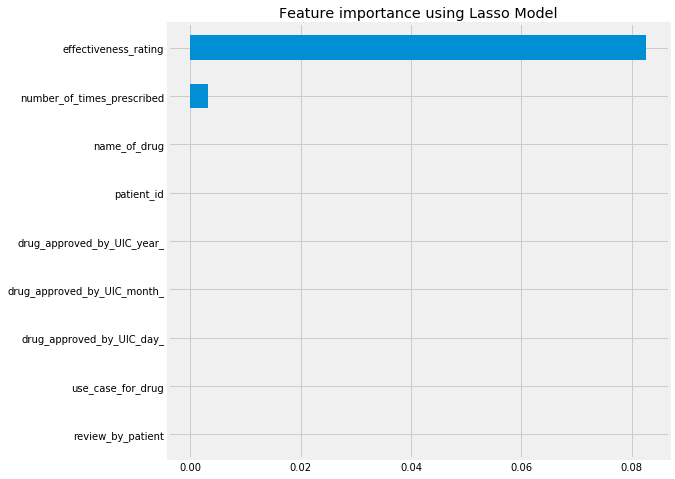

In [14]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X,Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [15]:
dataset = [train,test]
for x in dataset:
    del x['patient_id']
    del x['name_of_drug']
    del x['review_by_patient']
    del x['drug_approved_by_UIC_year_']
    del x['drug_approved_by_UIC_month_']
    del x['drug_approved_by_UIC_day_']
    del x['use_case_for_drug']
    

In [21]:
Y= train['base_score']
X = train.drop(['base_score'],axis=1)

In [22]:
for i in train.columns:
    print(f"{i} : {train[i].nunique()}")

effectiveness_rating : 10
number_of_times_prescribed : 303
base_score : 1383


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.3, random_state=42)

## Feature Scaling

In [26]:
import xgboost

xg = xgboost.XGBRegressor()
xg.fit(X_train, y_train)
pred_val_xg = xg.predict(X_val)

# If you want to use early stopping
# Here you may want to split the training data again
# instead of using X_val to avoid overfitting the the validation set
xg.fit(X_train,
       y_train,
       early_stopping_rounds=50,
       eval_metric="rmse",
       eval_set=[(X_val, y_val)])

[00:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.74484
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.1972
[2]	validation_0-rmse:4.70714
[3]	validation_0-rmse:4.26374
[4]	validation_0-rmse:3.86754
[5]	validation_0-rmse:3.51216
[6]	validation_0-rmse:3.19695
[7]	validation_0-rmse:2.91499
[8]	validation_0-rmse:2.66491
[9]	validation_0-rmse:2.44466
[10]	validation_0-rmse:2.24944
[11]	validation_0-rmse:2.07802
[12]	validation_0-rmse:1.92695
[13]	validation_0-rmse:1.79309
[14]	validation_0-rmse:1.67535
[15]	validation_0-rmse:1.56856
[16]	validation_0-rmse:1.47643
[17]	validation_0-rmse:1.40026
[18]	validation_0-rmse:1.33632
[19]	validation_0-rmse:1.27777
[20]	validation_0-rmse:1.22648
[21]	validation_0-rmse:1.18529
[22]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
y_pred = xg.predict(test)

In [31]:
ans = []

In [32]:
for i in range(len(y_pred)):
    ans.append(round(y_pred[i],2))

In [33]:
sub = test_1['patient_id']

In [34]:
sub = pd.DataFrame(sub)

In [35]:
sub['base_score']=ans

In [36]:
sub.to_csv("submission.csv",index=False)

In [37]:
sub

,patient_id,base_score
0,163740,8.39
1,39293,8.37
2,208087,5.99
3,23295,5.59
4,97013,6.55
...,...,...
10755,151266,6.15
10756,139347,4.17
10757,159999,7.16
10758,130945,5.41
